# Fidelity of Gibbs states under perturbation

In [45]:
import numpy as np
from scipy.linalg import eigh, sqrtm
from functools import reduce
import matplotlib.pyplot as plt

def get_n_colors(n):
    """
    Returns a list of n distinct colors for plotting using Matplotlib's tab10 colormap.

    Parameters:
    n (int): The number of colors to generate.

    Returns:
    list: A list of n color hex codes.
    """
    # Get the tab10 colormap from Matplotlib
    cmap = plt.get_cmap('tab20')
    
    # Generate the list of colors
    return [cmap(i % 10) for i in range(n)]

def safe_sqrtm_psd(A, eps=1e-6):
    # Symmetrize to ensure Hermiticity
    A = 0.5 * (A + A.conj().T)
    # Eigendecompose
    evals, evecs = np.linalg.eigh(A)
    # Clip small negative eigenvalues
    evals_clipped = np.clip(evals, eps, None)
    # Take square root of eigenvalues
    sqrt_evals = np.sqrt(evals_clipped)
    # Reconstruct
    return (evecs * sqrt_evals) @ evecs.conj().T

In [46]:
def random_Z_hamiltonian(n, m, k, seed=None):
    """
    Generate an n-qubit Hamiltonian H = sum_{i=1}^m s_i * P_i,
    where each P_i is a k-local Z-type Pauli string and
    each s_i is a random sign +/-1.

    Args:
        n     (int): number of qubits
        m     (int): number of terms to sum
        k     (int): locality (number of Z’s in each term)
        seed  (int, optional): RNG seed for reproducibility

    Returns:
        H (ndarray): 2^n x 2^n complex Hamiltonian matrix
    """
    if seed is not None:
        np.random.seed(seed)

    # Single-qubit operators
    Z = np.array([[1, 0],
                  [0, -1]], dtype=complex)
    I = np.eye(2, dtype=complex)

    H = np.zeros((2**n, 2**n), dtype=complex)

    # Support matrix
    supp = np.zeros((m, n), dtype=np.int8)

    for i in range(m):
        # 1) pick which k qubits get a Z
        active_qubits = np.random.choice(n, size=k, replace=False)
        supp[i,active_qubits] = 1

        # 2) build the tensor-product string
        ops = [Z if i in active_qubits else I for i in range(n)]
        term = reduce(np.kron, ops)

        # 3) random sign ±1
        sign = 1 if np.random.rand() < 0.5 else -1

        H += sign * term

    return H, supp

def random_X_perturbation(base_matrix, n, k, seed=None, verbose=False):
    """
    Generate a random X-type perturbation on a Z-type k-local Hamiltonian
    such that the underlying anticommutation graph is a union of stars.
    We generate the perturbation via a randomized greedy algorithm.
    """
    if seed is not None:
        np.random.seed(seed)

    # Single-qubit operators
    X = np.array([[0, 1],
                  [1, 0]], dtype=complex)
    I = np.eye(2, dtype=complex)

    H = np.zeros((2**n, 2**n), dtype=complex)

    # Support matrix
    allowed_idxs = set(np.arange(n))

    while True:
        # Sample a perturbative term and add it to the matrix
        sample = np.sort(np.random.choice(list(allowed_idxs), size=k, replace=False))
        if verbose:
            print(f"Adding X on {sample}")
        ops = [X if i in sample else I for i in range(n)]
        term = reduce(np.kron, ops)
        sign = 1 if np.random.rand() < 0.5 else -1
        H += sign * term

        # Cut out the qubits which overlap with the perturbation
        bad = set()
        for Z_term in base_matrix:
            if np.max(Z_term[sample]) == 1:
                bad = bad | set(np.flatnonzero(Z_term))
            
        allowed_idxs = allowed_idxs.difference(bad)
        if verbose:
            print(f"Cut indices {bad}; remaining: {allowed_idxs}")
        if len(allowed_idxs) < k:
            break

    return H


def gibbs_state(H, beta):
    # diagonalize H
    E, U = eigh(H)
    # Boltzmann weights
    w = np.exp(-beta * E)
    Z = np.sum(w)
    rho = (U * w) @ U.conj().T / Z
    return rho

def fidelity(rho1, rho2, eps=1e-12, safe=False):
    # sqrt of rho1
    sr = safe_sqrtm_psd(rho1, eps) if safe else sqrtm(rho1)
    # intermediate product
    prod = sr @ rho2 @ sr
    # fidelity
    sqrtprod = safe_sqrtm_psd(prod, eps) if safe else sqrtm(prod)
    return np.real(np.trace(sqrtprod))**2

## Ground states

In [50]:
MAX_N = 9
NUM_TRIALS = 10
k = 3
ns = (np.arange(MAX_N)+1)[k:]

def state_fidelity(s1, s2):
    return abs(np.dot(s1, s2))

state_fidelities = np.zeros((len(ns), NUM_TRIALS), dtype=np.float32)
for trial in range(NUM_TRIALS):
    for i, n in enumerate(ns):
        if n > 7:
            print(f"[{trial}] n = {n}")
        m = 3*n
        H, supp = random_Z_hamiltonian(n, m, k)
        perturbation = random_X_perturbation(supp, n, k)
        evals, evecs = np.linalg.eigh(H)
        print(evals)
        min_index = np.argmin(evals)
        s1 = evecs[:, min_index]
        evals, evecs = np.linalg.eigh(H+perturbation)
        min_index = np.argmin(evals)
        s2 = evecs[:, min_index]
        state_fidelities[i, trial] = state_fidelity(s1, s2)


[-4. -4. -2. -2. -2. -2.  0.  0.  0.  0.  2.  2.  2.  2.  4.  4.]
[-7. -7. -5. -5. -5. -5. -3. -3. -3. -3. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  3.  3.  3.  3.  5.  5.  5.  5.  7.  7.]
[-10. -10. -10. -10.  -8.  -8.  -8.  -8.  -6.  -6.  -4.  -4.  -4.  -4.
  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   2.   2.
   2.   2.   2.   2.   2.   2.   2.   2.   4.   4.   4.   4.   6.   6.
   8.   8.   8.   8.  10.  10.  10.  10.]
[-11. -11.  -7.  -7.  -7.  -7.  -7.  -7.  -7.  -7.  -7.  -7.  -7.  -7.
  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.  -5.
  -3.  -3.  -3.  -3.  -3.  -3.  -3.  -3.  -3.  -3.  -3.  -3.  -3.  -3.
  -3.  -3.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.
  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   3.   3.   3.   3.   3.   3.   3.   3.   3.   3. 

## Gibbs states

In [87]:
MAX_N = 8
NUM_TRIALS = 30

k = 3
ns = (np.arange(MAX_N)+1)[k:]
betas = [0.1, 1, 5, 10, 20, 30]
colors = get_n_colors(len(betas))
fidelities = np.zeros((NUM_TRIALS, len(betas), len(ns)), dtype=np.float32)

for trial in range(NUM_TRIALS):
    for i, n in enumerate(ns):
        m = int(np.ceil(2*n))
        H, supp = random_Z_hamiltonian(n, m, k)
        perturbation = random_X_perturbation(supp, n, k)

        for j, beta in enumerate(betas):
            if n > 7:
                print(f"[Trial {trial+1}] Working on n = {n}, beta = {beta}...")
            G = gibbs_state(H, beta)
            Gprime = gibbs_state(H + perturbation, beta)
            fidelities[trial, j, i] = fidelity(G, Gprime, safe=True)

[Trial 1] Working on n = 8, beta = 0.1...
[Trial 1] Working on n = 8, beta = 1...
[Trial 1] Working on n = 8, beta = 5...
[Trial 1] Working on n = 8, beta = 10...
[Trial 1] Working on n = 8, beta = 20...
[Trial 1] Working on n = 8, beta = 30...
[Trial 2] Working on n = 8, beta = 0.1...
[Trial 2] Working on n = 8, beta = 1...
[Trial 2] Working on n = 8, beta = 5...
[Trial 2] Working on n = 8, beta = 10...
[Trial 2] Working on n = 8, beta = 20...
[Trial 2] Working on n = 8, beta = 30...
[Trial 3] Working on n = 8, beta = 0.1...
[Trial 3] Working on n = 8, beta = 1...
[Trial 3] Working on n = 8, beta = 5...
[Trial 3] Working on n = 8, beta = 10...
[Trial 3] Working on n = 8, beta = 20...
[Trial 3] Working on n = 8, beta = 30...
[Trial 4] Working on n = 8, beta = 0.1...
[Trial 4] Working on n = 8, beta = 1...
[Trial 4] Working on n = 8, beta = 5...
[Trial 4] Working on n = 8, beta = 10...
[Trial 4] Working on n = 8, beta = 20...
[Trial 4] Working on n = 8, beta = 30...
[Trial 5] Working on

(6, 5)


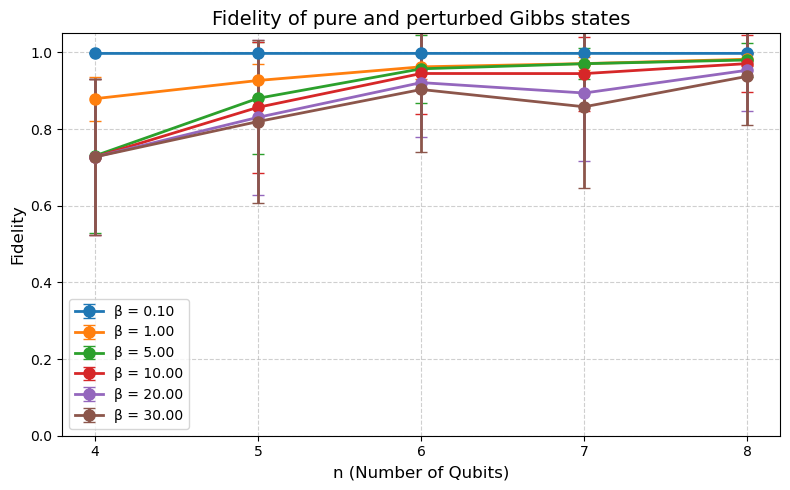

In [88]:
def plot_fidelity_vs_n(ns, betas, fidelities):
    """
    Plot fidelity vs n for each beta, averaging over trials and adding error bars.

    Args:
        ns         (1D array): array of n values (x-axis)
        betas      (1D array): array of beta values
        fidelities (3D array): shape (num_trials, len(betas), len(ns))
    """
    # Compute mean and std over trials (axis 0)
    mean_fid = fidelities.mean(axis=0)     # shape (len(betas), len(ns))
    std_fid = fidelities.std(axis=0)       # same shape
    print(mean_fid.shape)

    plt.figure(figsize=(8, 5))
    cmap = plt.get_cmap('tab10')

    for i, beta in enumerate(betas):
        color = cmap(i % 10)
        plt.errorbar(ns, mean_fid[i], yerr=std_fid[i],
                     marker='o', markersize=8, linewidth=2,
                     color=color, label=f'β = {beta:.2f}',
                     capsize=4, linestyle='-')

    plt.xlabel('n (Number of Qubits)', fontsize=12)
    plt.xticks(ns)
    plt.ylabel('Fidelity', fontsize=12)
    plt.title('Fidelity of pure and perturbed Gibbs states', fontsize=14)
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

plot_fidelity_vs_n(ns, betas, fidelities)